In [1]:
import pandas as pd

In [2]:
TICKER = 'NIFTY'
df = pd.read_csv("nifty50.csv")
df = df.head(12000)
df = df[['open', 'high', 'low', 'close']]

In [3]:
df = df.rename(columns={
    'open': f'Open_{TICKER}',
    'close': f'Close_{TICKER}',
    'low': f'Low_{TICKER}',
    'high': f'High_{TICKER}'
})
df.head()

,Open_NIFTY,High_NIFTY,Low_NIFTY,Close_NIFTY
0,5701.15,5704.65,5694.30,5697.00
1,5697.05,5698.35,5695.65,5697.50
2,5697.90,5697.90,5690.60,5692.15
3,5691.65,5694.70,5691.65,5693.90
4,5694.40,5695.05,5693.35,5694.55


In [4]:
def add_features(df, open, high, low, close):
    df = df.copy()
    df[f'Body_{TICKER}'] = (df[open] - df[close]).abs()
    df[f'Lower_Shadow_{TICKER}'] = (df[[open, close]].min(axis=1) - df[low])
    df[f'Upper_Shadow_{TICKER}'] = (df[high] - df[[open, close]].max(axis=1))
    return df

In [5]:
df = add_features(df, f"Open_{TICKER}", f"High_{TICKER}", f"Low_{TICKER}", f"Close_{TICKER}")

In [6]:
df.head()

,Open_NIFTY,High_NIFTY,Low_NIFTY,Close_NIFTY,Body_NIFTY,Lower_Shadow_NIFTY,Upper_Shadow_NIFTY
0,5701.15,5704.65,5694.30,5697.00,4.15,2.70,3.50
1,5697.05,5698.35,5695.65,5697.50,0.45,1.40,0.85
2,5697.90,5697.90,5690.60,5692.15,5.75,1.55,0.00
3,5691.65,5694.70,5691.65,5693.90,2.25,0.00,0.80
4,5694.40,5695.05,5693.35,5694.55,0.15,1.05,0.50


In [7]:
df['MA_5h'] = df[f"Close_{TICKER}"].rolling(window=300).mean()

In [8]:
def get_trend(df, i, TICKER='AAPL'):
    if i < 300:  # 5 hours = 300 rows for 1-minute data
        return None

    closes = df.iloc[i-5:i][f"Close_{TICKER}"]
    ma = df.iloc[i-5:i]['MA_5h']
    above = (closes > ma).sum()
    below = (closes < ma).sum()

    if above >= 3:
        return 'uptrend'
    elif below >= 3:
        return 'downtrend'
    else:
        return 'sideways'

In [9]:
def is_morning_star(df, i, TICKER=TICKER):
    if i < 2:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'downtrend':
        return False

    c0, c1, c2 = df.iloc[i-2], df.iloc[i-1], df.iloc[i]

    return (
        c0[f"Close_{TICKER}"] < c0[f"Open_{TICKER}"] and
        c1[f'Body_{TICKER}'] < 0.3 * (c1[f"High_{TICKER}"] - c1[f"Low_{TICKER}"]) and
        c2[f"Close_{TICKER}"] > c2[f"Open_{TICKER}"] and
        c2[f"Close_{TICKER}"] > (c0[f"Open_{TICKER}"] + c0[f"Close_{TICKER}"]) / 2
    )
def is_evening_star(df, i, TICKER=TICKER):
    if i < 2:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'uptrend':
        return False

    c0, c1, c2 = df.iloc[i-2], df.iloc[i-1], df.iloc[i]

    return (
        c0[f"Close_{TICKER}"] > c0[f"Open_{TICKER}"] and
        c1[f'Body_{TICKER}'] < 0.3 * (c1[f"High_{TICKER}"] - c1[f"Low_{TICKER}"]) and
        c2[f"Close_{TICKER}"] < c2[f"Open_{TICKER}"] and
        c2[f"Close_{TICKER}"] < (c0[f"Open_{TICKER}"] + c0[f"Close_{TICKER}"]) / 2
    )
def is_bullish_engulfing(df, i, TICKER=TICKER):
    if i < 1:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'downtrend':
        return False

    prev = df.iloc[i-1]
    curr = df.iloc[i]

    return (
        prev[f"Close_{TICKER}"] < prev[f"Open_{TICKER}"] and
        curr[f"Close_{TICKER}"] > curr[f"Open_{TICKER}"] and
        curr[f"Open_{TICKER}"] < prev[f"Close_{TICKER}"] and
        curr[f"Close_{TICKER}"] > prev[f"Open_{TICKER}"]
    )
def is_bearish_engulfing(df, i, TICKER=TICKER):
    if i < 1:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'uptrend':
        return False

    prev = df.iloc[i-1]
    curr = df.iloc[i]

    return (
        prev[f"Close_{TICKER}"] > prev[f"Open_{TICKER}"] and
        curr[f"Close_{TICKER}"] < curr[f"Open_{TICKER}"] and
        curr[f"Open_{TICKER}"] > prev[f"Close_{TICKER}"] and
        curr[f"Close_{TICKER}"] < prev[f"Open_{TICKER}"]
    )
def is_bullish_harami(df, i, TICKER=TICKER):
    if i < 1:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'downtrend':
        return False

    prev = df.iloc[i-1]
    curr = df.iloc[i]

    return (
        prev[f"Close_{TICKER}"] < prev[f"Open_{TICKER}"] and
        curr[f"Close_{TICKER}"] > curr[f"Open_{TICKER}"] and
        curr[f"Open_{TICKER}"] > prev[f"Close_{TICKER}"] and
        curr[f"Close_{TICKER}"] < prev[f"Open_{TICKER}"]
    )
def is_bearish_harami(df, i, TICKER=TICKER):
    if i < 1:
        return False
    trend = get_trend(df, i, TICKER)
    if trend != 'uptrend':
        return False

    prev = df.iloc[i-1]
    curr = df.iloc[i]

    return (
        prev[f"Close_{TICKER}"] > prev[f"Open_{TICKER}"] and
        curr[f"Close_{TICKER}"] < curr[f"Open_{TICKER}"] and
        curr[f"Open_{TICKER}"] < prev[f"Close_{TICKER}"] and
        curr[f"Close_{TICKER}"] > prev[f"Open_{TICKER}"]
    )


In [10]:
def label_patterns(df, TICKER=TICKER):
    labels = ['None'] * len(df)

    for i in range(len(df)):
        if is_morning_star(df, i, TICKER):
            labels[i] = 'Morning Star'
        elif is_evening_star(df, i, TICKER):
            labels[i] = 'Evening Star'
        elif is_bullish_engulfing(df, i, TICKER):
            labels[i] = 'Bullish Engulfing'
        elif is_bearish_engulfing(df, i, TICKER):
            labels[i] = 'Bearish Engulfing'
        elif is_bullish_harami(df, i, TICKER):
            labels[i] = 'Bullish Harami'
        elif is_bearish_harami(df, i, TICKER):
            labels[i] = 'Bearish Harami'

    df = df.copy()
    df['Pattern'] = labels
    return df

In [11]:
df = label_patterns(df)

In [12]:
pattern_counts = df['Pattern'].value_counts().to_dict()
print(pattern_counts)

{'None': 10435, 'Bullish Harami': 327, 'Bearish Harami': 279, 'Bearish Engulfing': 262, 'Evening Star': 240, 'Bullish Engulfing': 236, 'Morning Star': 221}


In [13]:
df_updated = df[df['Pattern'] != 'None'].reset_index(drop=True)

In [14]:
pattern_counts = df_updated['Pattern'].value_counts().to_dict()
print(pattern_counts)

{'Bullish Harami': 327, 'Bearish Harami': 279, 'Bearish Engulfing': 262, 'Evening Star': 240, 'Bullish Engulfing': 236, 'Morning Star': 221}


In [15]:
from pyts.image import GramianAngularField
import numpy as np
gaf_transformer = GramianAngularField(image_size=60, method='difference')
def gaf_window(df, i, TICKER=TICKER, window_size=60):
    if i < window_size:
        return None, None

    window_df = df.iloc[i - window_size:i]
    channels = []

    series_close = window_df[f"Close_{TICKER}"].values.reshape(1, -1)
    series_body = window_df[f"Body_{TICKER}"].values.reshape(1, -1)
    series_lower = window_df[f"Lower_Shadow_{TICKER}"].values.reshape(1, -1)
    series_upper = window_df[f"Upper_Shadow_{TICKER}"].values.reshape(1, -1)

    for series in [series_close, series_body, series_lower, series_upper]:
        gaf_image = gaf_transformer.fit_transform(series)[0]
        channels.append(gaf_image)

    gaf_img = np.stack(channels, axis=-1)  
    label = df.iloc[i]['Pattern']

    return gaf_img, label

In [16]:
def generate_gaf_dataset(df, TICKER=TICKER, window_size=60, sequence_length =5):
    sequences = []
    labels = []
    for i in range(window_size, len(df)):
        label = df.iloc[i]['Pattern']
        if label == 'None':
            continue  

        sequence = []
        valid = True

        for j in range(i - sequence_length + 1, i + 1):
            gaf, _ = gaf_window(df, j, TICKER, window_size)
            if gaf is None:
                valid = False
                break
            sequence.append(gaf)
        if valid:
            sequences.append(np.array(sequence))  # shape: (sequence_length, 60, 60, 4)
            labels.append(label)

    return sequences, labels


In [17]:
gaf_images, gaf_labels = generate_gaf_dataset(df)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999952691310402].


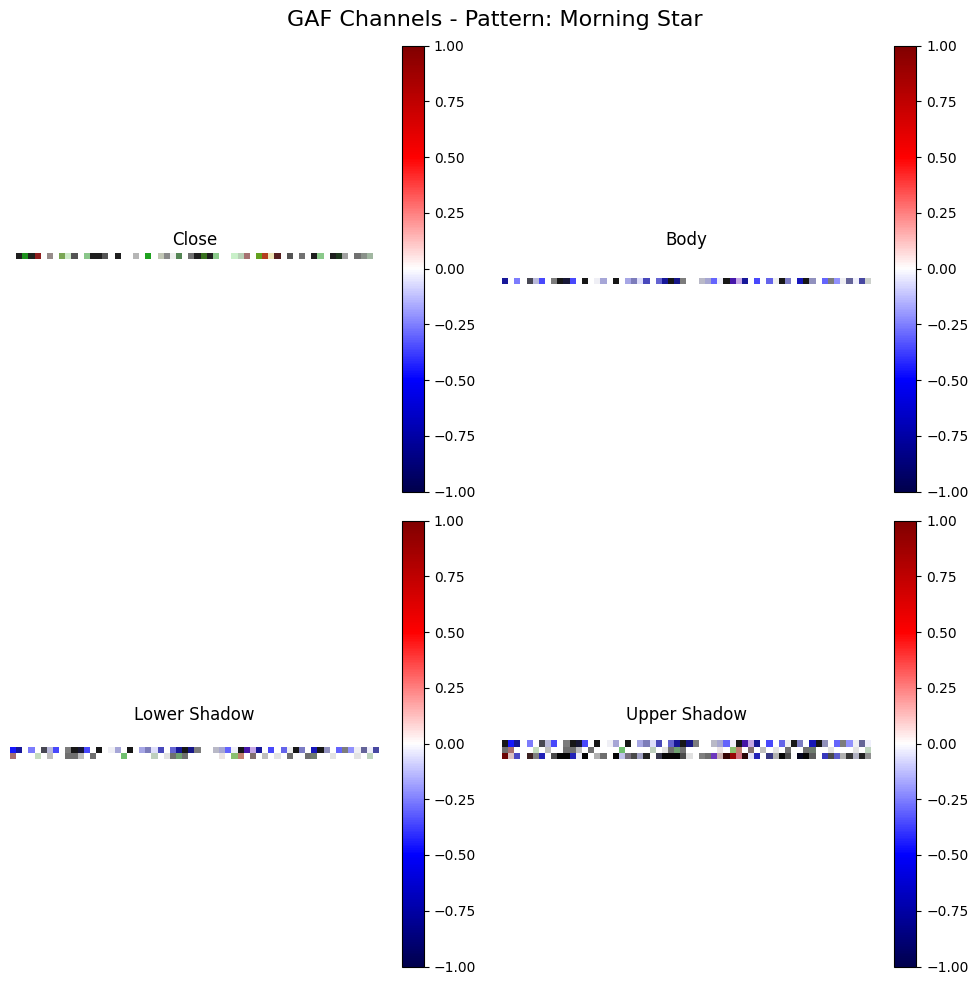

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gaf_channels(gaf_img, label=None):
    feature_names = ['Close', 'Body', 'Lower Shadow', 'Upper Shadow']
    
    plt.figure(figsize=(10, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(gaf_img[:, :, i], cmap='seismic', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title(feature_names[i])
        plt.axis('off')

    if label:
        plt.suptitle(f"GAF Channels - Pattern: {label}", fontsize=16)

    plt.tight_layout()
    plt.show()
plot_gaf_channels(gaf_images[0], label='Morning Star')


In [20]:
X = np.array(gaf_images)
y = np.array(gaf_labels)

In [21]:
from collections import Counter
print(Counter(y))

Counter({np.str_('Bullish Harami'): 327, np.str_('Bearish Harami'): 279, np.str_('Bearish Engulfing'): 262, np.str_('Evening Star'): 240, np.str_('Bullish Engulfing'): 236, np.str_('Morning Star'): 221})


In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # e.g., ['Bearish', 'Bullish', ...] → [0, 1, 2, ...]

y_onehot = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.35, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)


In [24]:
import numpy as np
y_train_labels = np.argmax(y_train, axis=1)
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert to dict for Keras
class_weights_dict = dict(enumerate(class_weights))


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, MaxPooling2D

In [26]:
import tensorflow as tf

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)

        # Compute cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Compute focal loss factor
        focal_factor = tf.pow(1 - y_pred, gamma)

        # Combine
        loss = alpha * focal_factor * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_lstm_model(sequence_length=7, image_size=60, channels=4, num_classes=6):
    input_layer = Input(shape=(sequence_length, image_size, image_size, channels))

    # CNN feature extractor (shared across time via TimeDistributed)
    def cnn_block():
        return Sequential([
            Conv2D(32, (3, 3), padding='same'),
            MaxPooling2D(),
            Activation('relu'),
            Dropout(0.25),
            Conv2D(64, (3, 3), padding='same'),
            MaxPooling2D(),
            Activation('relu'),
            Flatten()
        ])
    
    cnn = cnn_block()
    x = TimeDistributed(cnn)(input_layer)   # Output shape: (batch, seq_len, features)

    # LSTM to process sequence of CNN features
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(1e-3),
                metrics=['accuracy'],
                loss=categorical_focal_loss())
    return model
early_stop = EarlyStopping(
    monitor='val_loss',    # or 'val_accuracy', depending on your focus
    patience=5,            # number of epochs with no improvement before stopping
    restore_best_weights=True # restore model weights from the epoch with the best value of the monitored quantity
)


In [28]:
model = build_cnn_lstm_model(sequence_length=5)
model.fit(X_train, y_train, epochs=60, batch_size=32, 
        validation_data=(X_val, y_val), callbacks = [early_stop])
model.evaluate(X_test, y_test)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.1726 - loss: 0.3396 - val_accuracy: 0.1861 - val_loss: 0.3047
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.2189 - loss: 0.3061 - val_accuracy: 0.2555 - val_loss: 0.2893
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.2627 - loss: 0.2958 - val_accuracy: 0.2591 - val_loss: 0.2718
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.2863 - loss: 0.2791 - val_accuracy: 0.2956 - val_loss: 0.2647
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.2856 - loss: 0.2715 - val_accuracy: 0.3029 - val_loss: 0.2558
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.3469 - loss: 0.2580 - val_accuracy: 0.3759 - val_loss: 0.2374
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.4143 - loss: 0.2253 - val_accuracy: 0.4562 - val_loss: 0.2029
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.4466 - loss: 0.1971 - val_accuracy: 0.

[0.1621720939874649, 0.569343090057373]

In [29]:
y_prob = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_prob = np.argmax(y_prob, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


<Figure size 600x600 with 0 Axes>

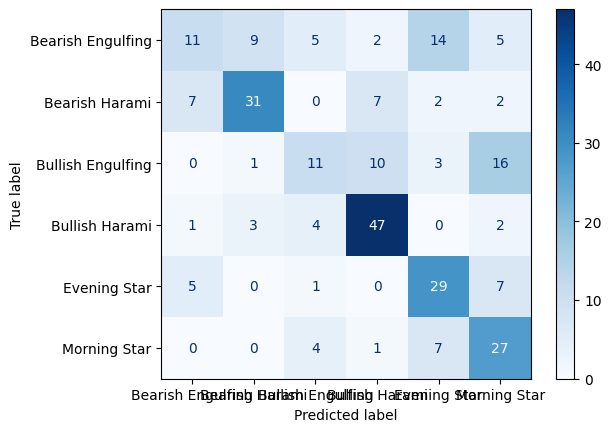

In [30]:
classes = np.unique(gaf_labels)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_prob))

              precision    recall  f1-score   support

           0       0.46      0.24      0.31        46
           1       0.70      0.63      0.67        49
           2       0.44      0.27      0.33        41
           3       0.70      0.82      0.76        57
           4       0.53      0.69      0.60        42
           5       0.46      0.69      0.55        39

    accuracy                           0.57       274
   macro avg       0.55      0.56      0.54       274
weighted avg       0.56      0.57      0.55       274

